In [80]:
import numpy as np
import pandas as pd
from fast_ml.model_development import train_valid_test_split
from string import punctuation
import re
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.naive_bayes as naive_bayes
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shivamarora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shivamarora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Utility Functions

In [3]:
def convert_tweet_tree_to_df(tweet_id, year):
    tweet_tree = pd.read_csv( 'twitter' + year + '/tree/' + str(tweet_id) + '.txt', 
                             header=None, sep=',', engine='python')
    tweet_tree.columns = ["P1", "Tw1", "Udf", "Tw2", "T2"]
    tweet_tree['P1'] = tweet_tree['P1'].str[1:]
    temp = tweet_tree['Udf'].str.split("\]->\[", n = 1, expand = True)
    tweet_tree['T1'] = temp[0]
    tweet_tree['P2'] = temp[1]
    tweet_tree = tweet_tree[['P1','Tw1','T1','P2','Tw2','T2']]
    tweet_tree['T2'] = tweet_tree['T2'].str[:-1]
    return tweet_tree

In [4]:
def get_tweet_publisher(tweet, year, _):
    tweet_df = convert_tweet_tree_to_df(tweet['id'], year)
    return tweet_df['P2'][0][1:-1]

In [5]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in punctuation])
    return punctuationfree

In [6]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def remove_emoticons(text):
    return emoji_pattern.sub(r'', text)
    

In [7]:
def tokenization(text):
    return word_tokenize(str(text))

In [8]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
def remove_stopwords(text):
    output= [i for i in text if i not in stopWords]
    return output

In [9]:
porter_stemmer = PorterStemmer()
def stemming(text):
    stem_text = [porter_stemmer.stem(word) for word in text]
    return stem_text

In [10]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizer(text):
    lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
    return lemm_text

## Reading Datasets

In [11]:
data_15 = pd.read_csv('twitter15/source_tweets.txt', sep="\t", header=None)
data_15.columns = ["id", "content"]

In [12]:
labels_15 = pd.read_csv('twitter15/label.txt', sep=":", header=None)
labels_15.columns = ["label", "id"]

In [13]:
data_15 = data_15.join(labels_15.set_index('id'), on='id')

In [14]:
data_15['publisher'] = data_15.apply(get_tweet_publisher, axis=1, args=("15", _))

In [15]:
data_15.head()

,id,content,label,publisher
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
1,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,30313925
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,2557521
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,2883841


In [16]:
data_15.shape

(1490, 4)

In [17]:
data_15.count()

id           1490
content      1490
label        1490
publisher    1490
dtype: int64

In [18]:
data_16 = pd.read_csv('twitter16/source_tweets.txt', sep="\t", header=None)
data_16.columns = ["id", "content"]

In [19]:
labels_16 = pd.read_csv('twitter16/label.txt', sep=":", header=None)
labels_16.columns = ["label", "id"]

In [20]:
data_16 = data_16.join(labels_16.set_index('id'), on='id')

In [21]:
data_16['publisher'] = data_16.apply(get_tweet_publisher, axis=1, args=("16", _))

In [22]:
data_16.head()

,id,content,label,publisher
0,656955120626880512,correct predictions in back to the future ii URL,false,1942819082
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,true,44945327
2,613404935003217920,cops bought the alleged church shooter burger ...,false,14511951
3,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
4,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989


In [23]:
data_16.shape

(818, 4)

In [24]:
data_16.count()

id           818
content      818
label        818
publisher    818
dtype: int64

In [25]:
data = pd.concat([data_15, data_16], ignore_index=True)

In [26]:
data

,id,content,label,publisher
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
1,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,30313925
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,2557521
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,2883841
...,...,...,...,...
2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,14075928
2304,544269749405097984,breaking: live coverage of hostage situation u...,true,15250661
2305,760109079133990912,“after school satan clubs”? URL,unverified,44945327
2306,779633844680962048,this network of tunnels is from the stone age ...,unverified,918346674


In [27]:
data.shape

(2308, 4)

In [28]:
len(data["id"].unique())

2139

In [29]:
data = data.drop_duplicates(subset=None, keep='first', inplace=False)

In [30]:
data

,id,content,label,publisher
0,731166399389962242,🔥ca kkk grand wizard 🔥 endorses @hillaryclinto...,unverified,431917957
1,714598641827246081,an open letter to trump voters from his top st...,unverified,94215989
2,691809004356501505,america is a nation of second chances —@potus ...,non-rumor,30313925
3,693204708933160960,"brandon marshall visits and offers advice, sup...",non-rumor,2557521
4,551099691702956032,rip elly may clampett: so sad to learn #beverl...,true,2883841
...,...,...,...,...
2302,693171092555431936,watch: tommy chong made a pro-bernie sanders v...,non-rumor,16664681
2303,693546915892428800,jeb bush campaign kicks off 3-state farewell t...,non-rumor,14075928
2304,544269749405097984,breaking: live coverage of hostage situation u...,true,15250661
2306,779633844680962048,this network of tunnels is from the stone age ...,unverified,918346674


In [31]:
len(data["publisher"].unique())

906

## Preprocessing

In [32]:
#Punctuation Removal
data['content']= data['content'].apply(lambda x:remove_punctuation(x))

In [33]:
#Emoticons Removal
data['content']= data['content'].apply(lambda x:remove_emoticons(x))

In [34]:
#Numbers Removal
remove_digits = str.maketrans('', '', digits)
data['content'] = data['content'].apply(lambda x: x.translate(remove_digits))

In [35]:
#lowering the text
data['content']= data['content'].apply(lambda x: x.lower())

In [36]:
#tokenization
data['content']= data['content'].apply(lambda x: tokenization(x))

In [37]:
#Removing stop words
data['content']= data['content'].apply(lambda x:remove_stopwords(x))

In [38]:
#Stemming
data['content']=data['content'].apply(lambda x: stemming(x))

In [39]:
#Lemmatization
data['content']=data['content'].apply(lambda x:lemmatizer(x))

In [40]:
data['content'].head()

0    [ca, kkk, grand, wizard, endors, hillaryclinto...
1    [open, letter, trump, voter, top, strategisttu...
2    [america, nation, second, chanc, —potu, new, r...
3    [brandon, marshal, visit, offer, advic, suppor...
4    [rip, elli, may, clampett, sad, learn, beverly...
Name: content, dtype: object

In [41]:
data['label'].value_counts()

true          579
non-rumor     579
false         575
unverified    406
Name: label, dtype: int64

In [42]:
label_map = {'false' : 0, 'unverified' : 1, 'non-rumor' : 2, 'true' : 3}

In [43]:
data['label'] = data['label'].map(label_map)

In [45]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'label', 
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1)

In [46]:
print(y_train.value_counts())

3    475
0    465
2    450
1    321
Name: label, dtype: int64


In [47]:
print(y_valid.value_counts())

2    66
0    59
3    48
1    41
Name: label, dtype: int64


In [48]:
print(y_test.value_counts())

2    63
3    56
0    51
1    44
Name: label, dtype: int64


In [60]:
def identity_tokenizer(text):
    return text
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, max_features=1000)
tfidf_vectorizer.fit(data['content'])

TfidfVectorizer(lowercase=False, max_features=1000, stop_words='english',
                tokenizer=<function identity_tokenizer at 0x7fd4ddf881f0>)

In [61]:
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train['content'])

In [62]:
tfidf_valid_vectors = tfidf_vectorizer.fit_transform(X_valid['content'])

In [63]:
tfidf_test_vectors = tfidf_vectorizer.fit_transform(X_test['content'])

# Classification

## SVM Multiclass Classification

In [64]:
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [78]:
labels = [0,1,2,3]
def plot_cm(y_true,y_pred,labels):
  cm = confusion_matrix(y_true, y_pred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, fmt="d")
  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Labels')
  ax.set_ylabel('True Labels')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

Kernel: linear
Validation
              precision    recall  f1-score   support

           0       0.31      0.32      0.32        59
           1       0.24      0.24      0.24        41
           2       0.36      0.36      0.36        66
           3       0.38      0.35      0.37        48

    accuracy                           0.33       214
   macro avg       0.32      0.32      0.32       214
weighted avg       0.33      0.33      0.33       214



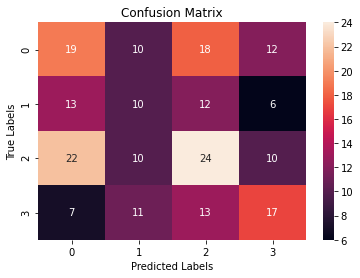


Testing
              precision    recall  f1-score   support

           0       0.25      0.47      0.32        51
           1       0.21      0.11      0.15        44
           2       0.30      0.27      0.29        63
           3       0.43      0.29      0.34        56

    accuracy                           0.29       214
   macro avg       0.30      0.28      0.28       214
weighted avg       0.30      0.29      0.28       214



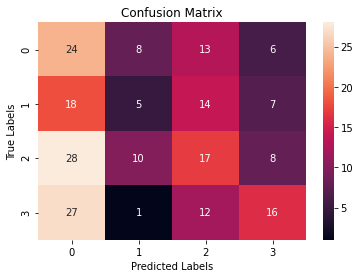

In [81]:
clf = svm.SVC(kernel='linear')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: linear')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

Kernel: rbf
Validation
              precision    recall  f1-score   support

           0       0.24      0.27      0.26        59
           1       0.19      0.07      0.11        41
           2       0.31      0.50      0.38        66
           3       0.32      0.17      0.22        48

    accuracy                           0.28       214
   macro avg       0.26      0.25      0.24       214
weighted avg       0.27      0.28      0.26       214



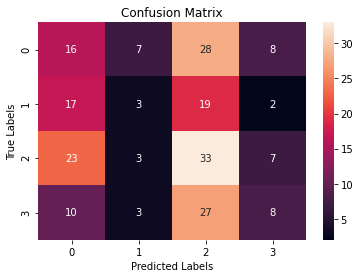


Testing
              precision    recall  f1-score   support

           0       0.29      0.47      0.36        51
           1       0.11      0.02      0.04        44
           2       0.24      0.35      0.29        63
           3       0.45      0.25      0.32        56

    accuracy                           0.29       214
   macro avg       0.27      0.27      0.25       214
weighted avg       0.28      0.29      0.26       214



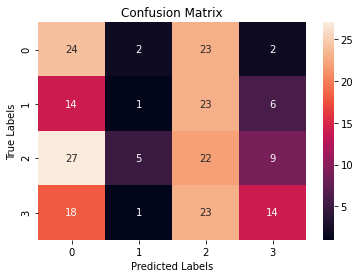

In [84]:
clf = svm.SVC(kernel='rbf')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: rbf')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)

Kernel: sigmoid
Validation
              precision    recall  f1-score   support

           0       0.28      0.32      0.30        59
           1       0.19      0.17      0.18        41
           2       0.32      0.30      0.31        66
           3       0.37      0.35      0.36        48

    accuracy                           0.29       214
   macro avg       0.29      0.29      0.29       214
weighted avg       0.29      0.29      0.29       214



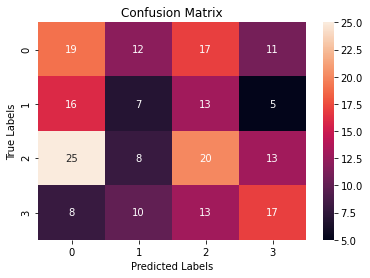


Testing
              precision    recall  f1-score   support

           0       0.26      0.49      0.34        51
           1       0.15      0.09      0.11        44
           2       0.31      0.27      0.29        63
           3       0.45      0.30      0.36        56

    accuracy                           0.29       214
   macro avg       0.29      0.29      0.28       214
weighted avg       0.30      0.29      0.28       214



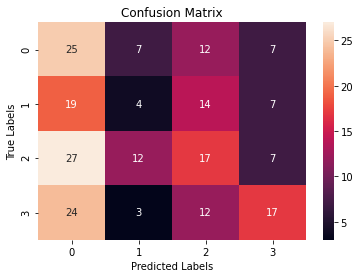

In [85]:
clf = svm.SVC(kernel='sigmoid')
clf.fit(tfidf_train_vectors,y_train)
y_pred_valid = clf.predict(tfidf_valid_vectors)
y_pred_test = clf.predict(tfidf_test_vectors)

print('Kernel: sigmoid')
print('Validation')
print(classification_report(y_valid,y_pred_valid))
plot_cm(y_valid,y_pred_valid,labels)
print()
print('Testing')
print(classification_report(y_test,y_pred_test))
plot_cm(y_test,y_pred_test,labels)